https://www.kaggle.com/massquantity/all-you-need-is-pca-lb-0-11421-top-4  

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline,make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA,KernelPCA
from sklearn.preprocessing import Imputer


In [6]:
# 读入训练数据和测试数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [7]:
# 查看train_data的特征列的名称
train_data.columns
# 实际上用下面的train_data.head()查看更简洁

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


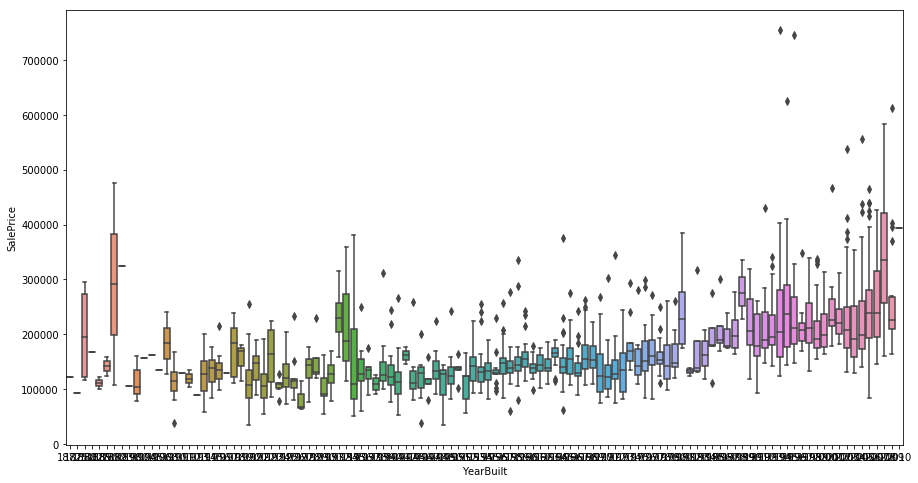

In [9]:
# 原始的特征比价多，选择其中的建造年份（YearBuilt）和销售价格进行可视化分析
plt.figure(1,figsize=(15,8))
sns.boxplot(train_data.YearBuilt,train_data.SalePrice)

It seems that the price of recent-built houses are higher. So later I 'll use labelencoder for three "Year" feature（为什么？）

In [10]:
plt.figure(figsize=(12,6))

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

(0, 800000)

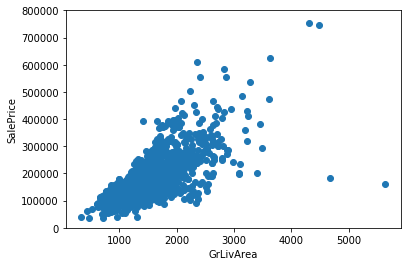

In [11]:
plt.scatter(x=train_data.GrLivArea,y=train_data.SalePrice)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.ylim(0,800000)

从散点图中可以发现有些离群的点，将其删除

In [27]:
train_data.drop(train_data[(train_data.GrLivArea>4000)&(train_data.SalePrice<300000)].index,inplace=True)

In [28]:
full = pd.concat([train_data, test_data], ignore_index=True)
# full

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


将训练和测试的concat：测试数据集也有空特征，需要进行统一的清洗。

In [29]:
full.drop(['Id'],axis=1,inplace=True)

In [30]:
full.shape

(2917, 80)

# 数据清洗（data cleaning）

In [33]:
lost = full.isnull().sum() # 统计每一列特征缺失的特征数
lost[lost>0].sort_values(ascending=False) # 将缺失数据特征的降序排列

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64